G2Net Gravitational Wave Detection - Exploratoy Data Analysis
============================================================


- [1 Data Inspection](#data-inspection)
  - [1.1 Libraries and definitions](#libraries-definitions)
  - [1.2 Labels distribution](#label-distribution)
  - [1.3 Time series plots](#time-series-plots)
  - [1.4 Power spectral density](#PSD)
- [2 Time-frequency analysis on raw data](#time-frequency-analysis-raw-data)
  - [2.1 Spectrograms by STFT](#spectrograms-stft)
  - [2.2 Mel-frequency cepstrum](#MFCC)
  - [2.3 Spectrograms by constant Q transform (CQT)](#spectrograms-CQT)
  - [2.4 Scalograms by wavelet transform](#scalograms-wavelet)
- [3 Time-frequency analysis on filtered data](#time-frequency-analysis-filtered-data)

# 1 Data Inspection <a class="anchor" id="data-inspection">

## 1.1 Libraries and definitions <a class="anchor" id="libraries-definitions">

In [1]:
# Python libs
import warnings
import joblib
from pathlib import Path
from math import ceil
import numpy as np
import pandas as pd
from scipy import signal

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Signal processing
import librosa
import pywt
from nnAudio.features.cqt import CQT1992v2
import torch

# Module settings
#mpl.rc("figure", dpi=144)
sns.set()
#pd.set_option('display.max_columns', None)  # show all columns

In [2]:
DATA_INPUT_DIR = "data/"
TRAIN_DIR = DATA_INPUT_DIR + "train/"
TEST_DIR = DATA_INPUT_DIR + "test/"
TRAIN_LABELS_CSV = DATA_INPUT_DIR + "training_labels.csv"

## 1.2 Training class distribution <a class="anchor" id="label-distribution">

In [3]:
labels = pd.read_csv(TRAIN_LABELS_CSV)
labels

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


0    280070
1    279930
Name: target, dtype: int64

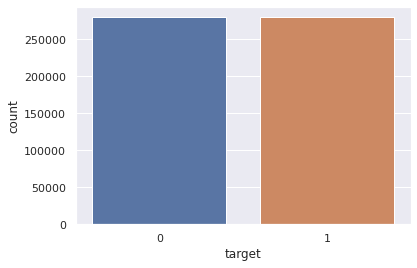

In [4]:
labels['target'].value_counts()
_ = sns.countplot(x='target', data=labels)

- There are 560000 training time series.
- There are 280070 non-GW series and 279930 GW series, almost equally distributed.
- Each time series

## 1.3 Time series plots - Positive vs. Negative <a class="anchor" id="time-series-plots">

In [4]:
def plot_sample(X, sample_id: str, label: int):
    fig = plt.figure(figsize=(15, 8))
    grid = mpl.gridspec.GridSpec(4, 2, width_ratios=[4, 1], hspace=0.5)
    time = np.arange(0, 4096) / 2048

    ax00 = fig.add_subplot(grid[0, 0])
    _ = ax00.set(xlabel='')
    _ = ax00.set(title="LIGO Hanford")
    _ = ax00.plot(time, X[0], c=sns.color_palette()[0])

    ax01 = fig.add_subplot(grid[0, 1])
    _ = ax01.set(xlabel='')
    _ = sns.histplot(y=X[0], ax=ax01, kde=True, color=sns.color_palette()[0])

    ax10 = fig.add_subplot(grid[1, 0])
    _ = ax10.set(xlabel='')
    _ = ax10.set(title="LIGO Livingston")
    _ = ax10.plot(time, X[1], c=sns.color_palette()[1])

    ax11 = fig.add_subplot(grid[1, 1])
    _ = ax11.set(xlabel='')
    _ = sns.histplot(y=X[1], ax=ax11, kde=True, color=sns.color_palette()[1])

    ax20 = fig.add_subplot(grid[2, 0])
    _ = ax20.set(xlabel='')
    _ = ax20.set(title="Virgo")
    _ = ax20.plot(time, X[2], c=sns.color_palette()[2])

    ax21 = fig.add_subplot(grid[2, 1])
    _ = ax21.set(xlabel='')
    _ = sns.histplot(y=X[2], ax=ax21, kde=True, color=sns.color_palette()[2])

    ax3 = fig.add_subplot(grid[3, 0])
    ax3.set(xlabel='Time (s)')
    _ = ax3.plot(time, X[0], label="LIGO Hanford")
    _ = ax3.plot(time, X[1], label="LIGO Livingston")
    _ = ax3.plot(time, X[2], label="Virgo")
    plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
    
    ylim = ax3.get_ylim()
    for ax in [ax00, ax01, ax10, ax11, ax20, ax21]:
        ax.set(ylim=ylim)

    fig.suptitle(f"{sample_id}, label={label}", y=0.94)

In [5]:
def get_random_sample_ids(labels, n: int):
    sample_ids = {}
    for label, g in labels.groupby('target'):
        sample_ids[label] = np.random.choice(g['id'], n)    
    return sample_ids

def get_data_by_sample_id(sample_id: str, train_or_test: str='train'):
    path = f"{DATA_INPUT_DIR}{train_or_test}/{sample_id[0]}/{sample_id[1]}/{sample_id[2]}/{sample_id}.npy"
    return np.load(path)

def get_label_by_sample_id(sample_id, labels):
    y = labels.query(f"id == '{sample_id}'")['target'].iloc[0]
    return y

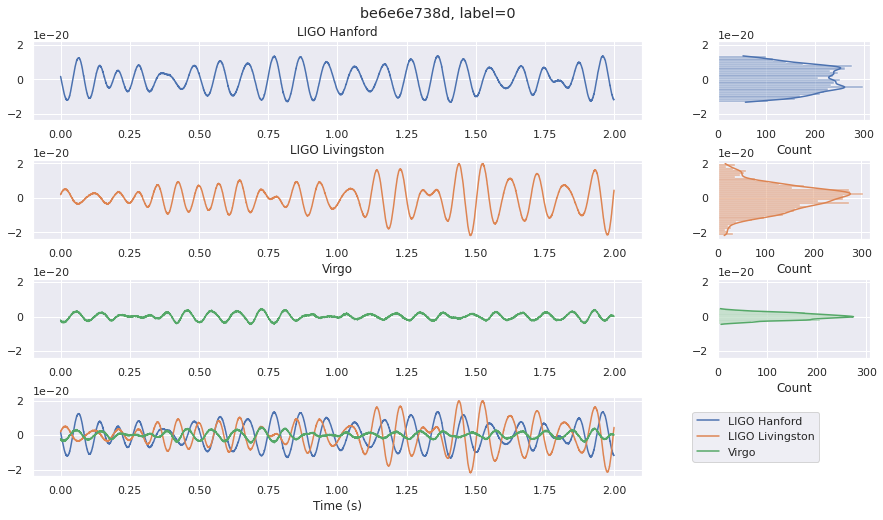

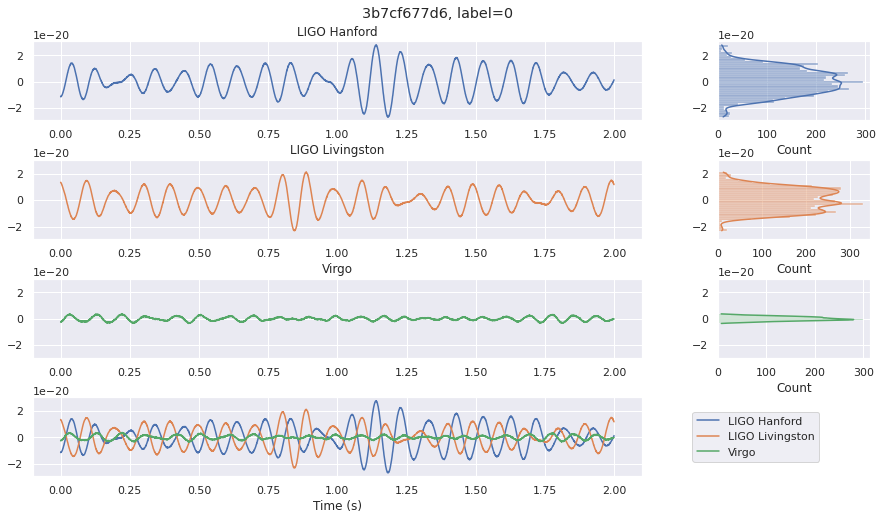

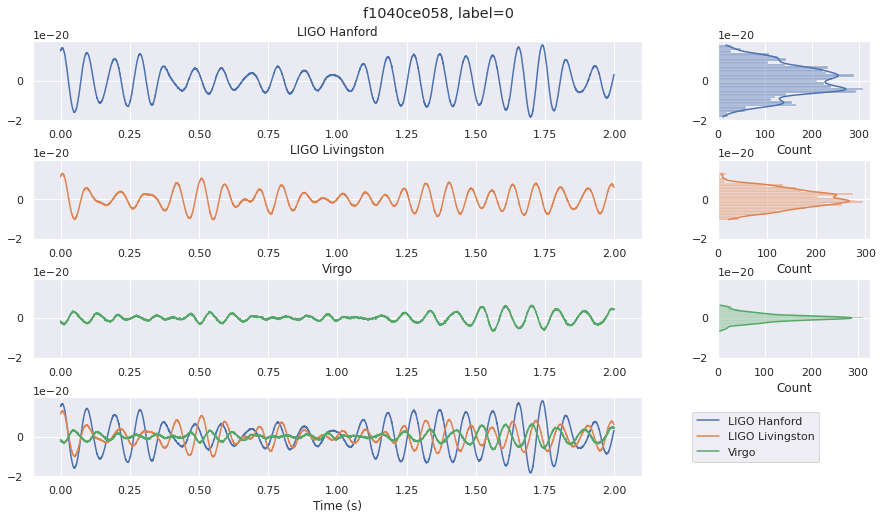

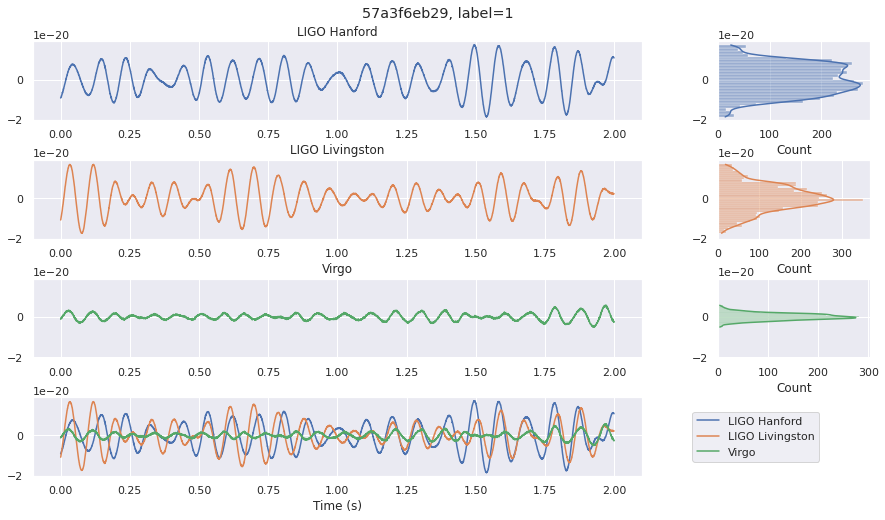

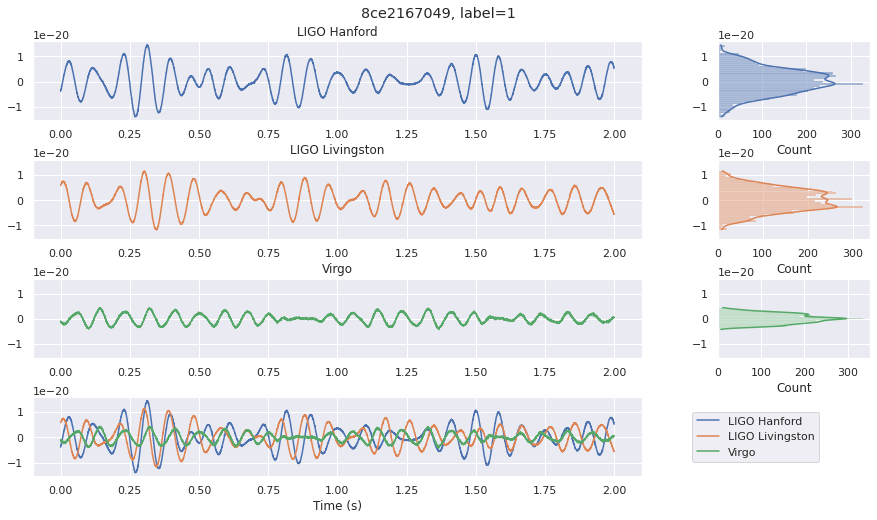

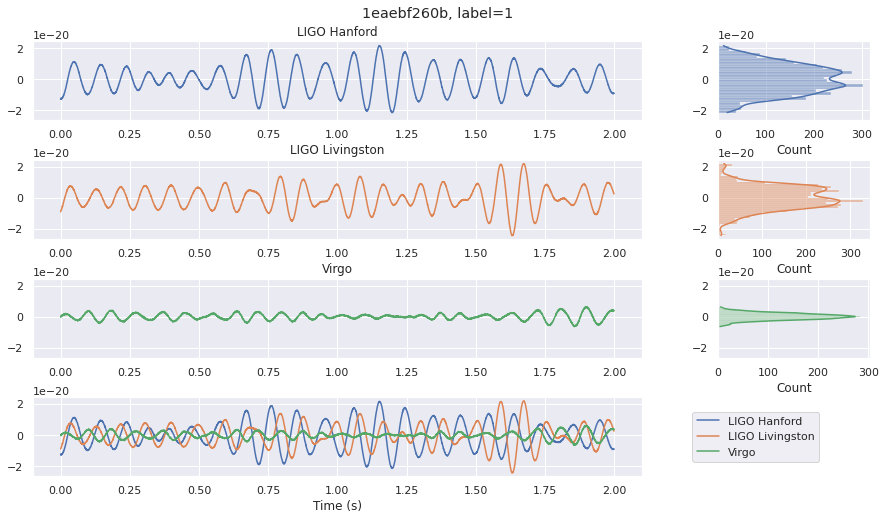

In [60]:
sample_ids = get_random_sample_ids(labels, n=3)
for label in (0, 1):
    for sample_id in sample_ids[label]:
        X = get_data_by_sample_id(sample_id, 'train')
        y = get_label_by_sample_id(sample_id, labels)
        plot_sample(X, sample_id, label=y)


## 1.4 Power spectral density <a class="anchor" id="PSD">

In [8]:
sample_ids = get_random_sample_ids(labels, n=3)
sample_ids

{0: array(['d351acade4', 'dd3eaf0c8d', 'd64eae144c'], dtype=object),
 1: array(['653e8bb6c3', '11661508e9', '702cf16e0b'], dtype=object)}

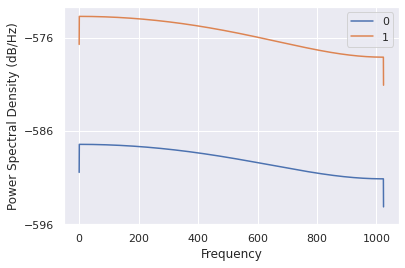

In [20]:
_ = plt.psd(get_data_by_sample_id('d351acade4'), NFFT=4096, Fs=2048, label='0')
_ = plt.psd(get_data_by_sample_id('653e8bb6c3'), NFFT=4096, Fs=2048, label='1')
_ = plt.legend()

# 2 Time-frequency analysis on raw data <a class="anchor" id="time-frequency-analysis-raw-data"></a>

## 2.1 Spectrograms by STFT <a class="anchor" id="spectrograms-stft"></a>

In [45]:
def plot_spectrograms(sample_X, sample_y, sample_id):
    global sites
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    _ = plt.suptitle(f"{sample_id}, label={sample_y}")
    for i, site in enumerate(sites):
        X = sample_X[i]
        X = X / X.max()
        X_stft = librosa.stft(X)
        X_stft_db = librosa.amplitude_to_db(abs(X_stft))
        ax = plt.subplot(1, 3, i+1)
        _ = ax.set(title=site)
        _ = specshow(X_stft_db, sr=2048, x_axis='time', y_axis='log', vmin=-30, vmax=50)
        _ = plt.colorbar()

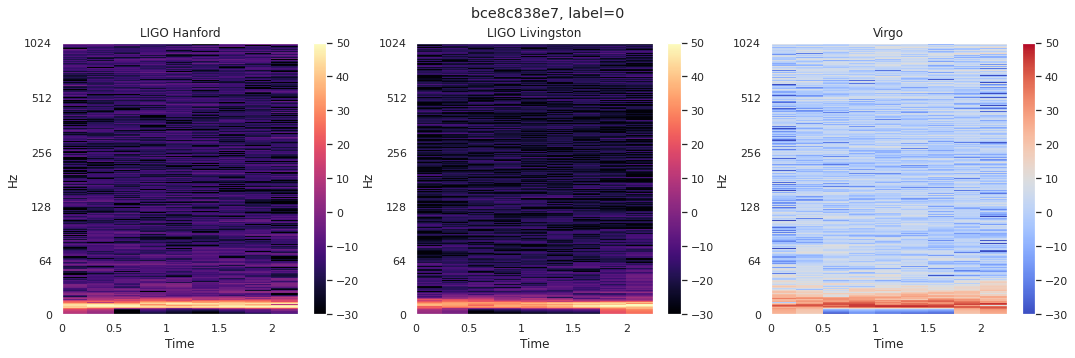

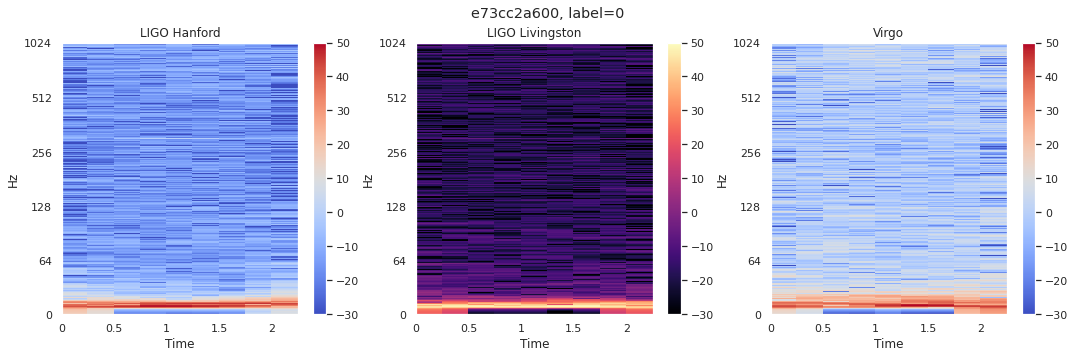

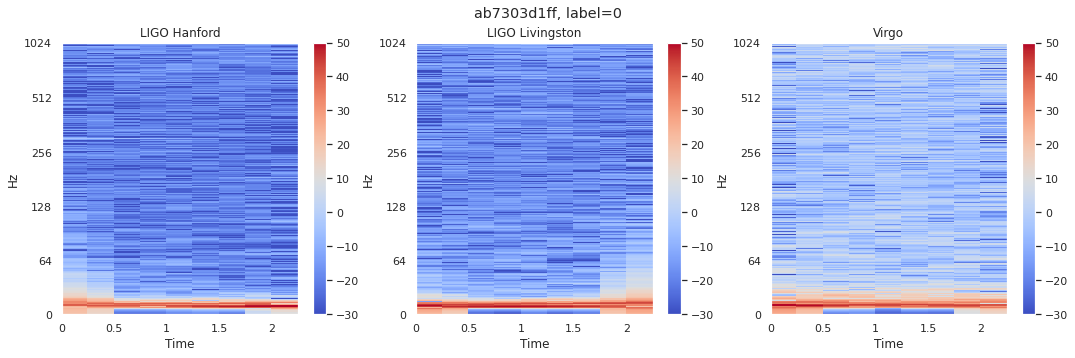

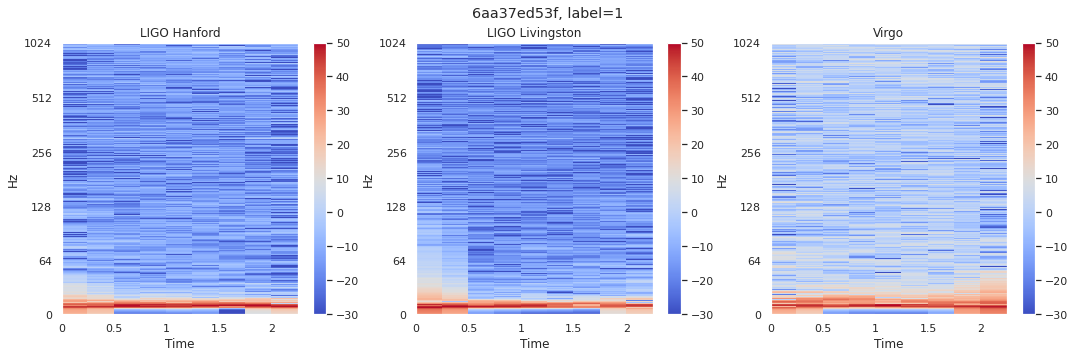

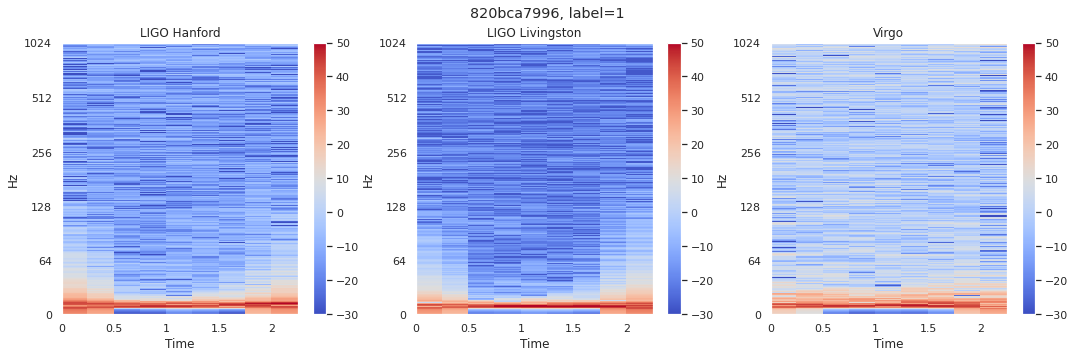

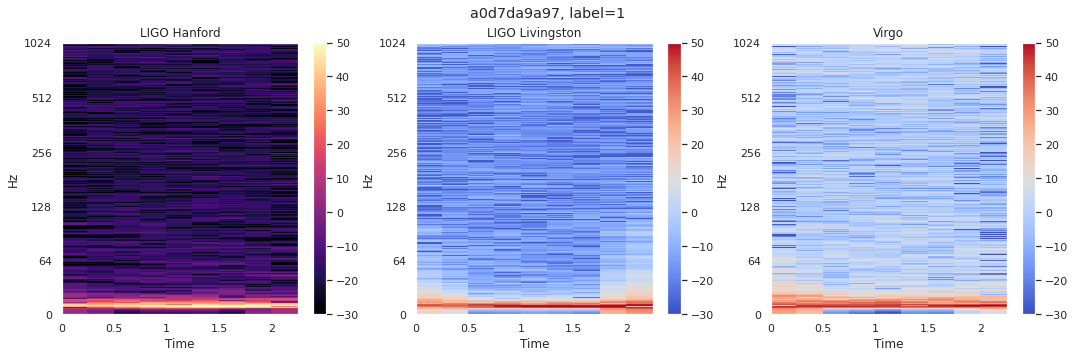

In [48]:
sample_ids = get_random_sample_ids(labels, n=3)

sites = "LIGO Hanford", "LIGO Livingston", "Virgo"
for label in (0, 1):
    for sample_id in sample_ids[label]:
        sample_X = get_data_by_sample_id(sample_id, 'train')
        sample_y = get_label_by_sample_id(sample_id, labels)
        plot_spectrograms(sample_X, sample_y, sample_id)

## 2.2 Mel-frequency cepstrum <a class="anchor" id="MFCC"></a>

In [71]:
def plot_mfc(sample_X, sample_y, sample_id, sampling_rate=2048):
    global sites
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    _ = plt.suptitle(f"{sample_id}, label={sample_y}")
    for i, site in enumerate(sites):
        X = sample_X[i]
        X = X / X.max()
        mfc = librosa.feature.mfcc(X, sr=sampling_rate)
        ax = plt.subplot(1, 3, i+1)
        _ = ax.set(title=site)
        mfc_db = librosa.amplitude_to_db(abs(mfc))
        _ = specshow(mfc_db, sr=sampling_rate, x_axis='time', y_axis=None, vmin=-20, vmax=50)
        _ = plt.colorbar()

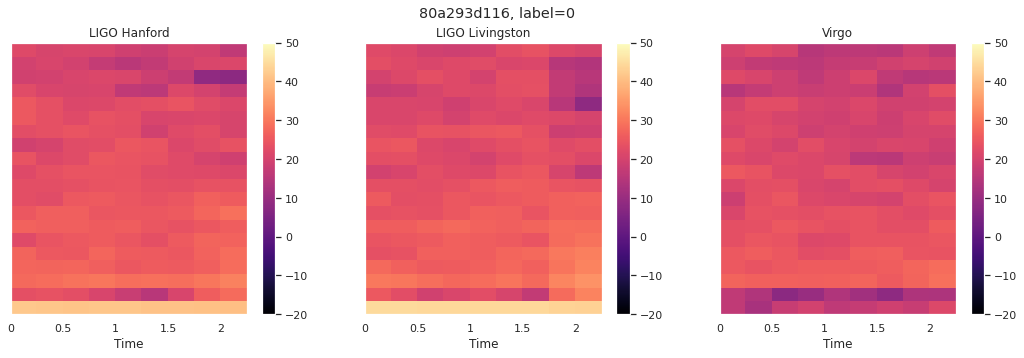

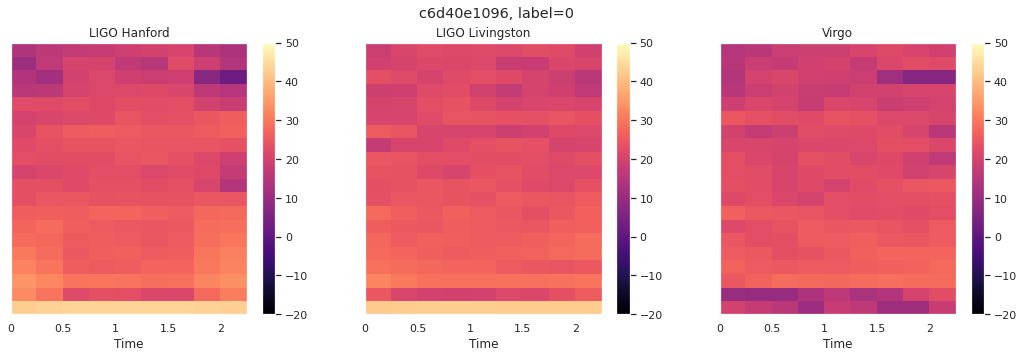

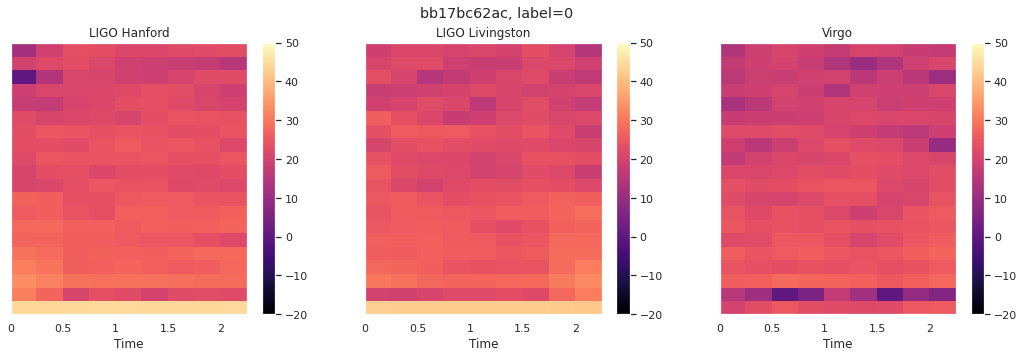

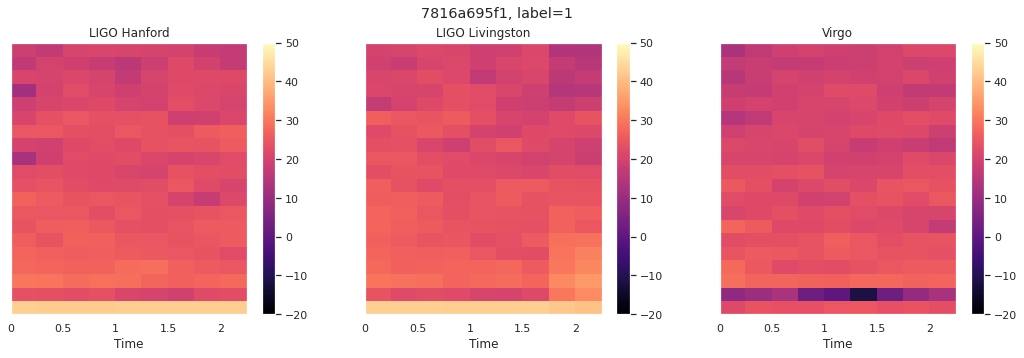

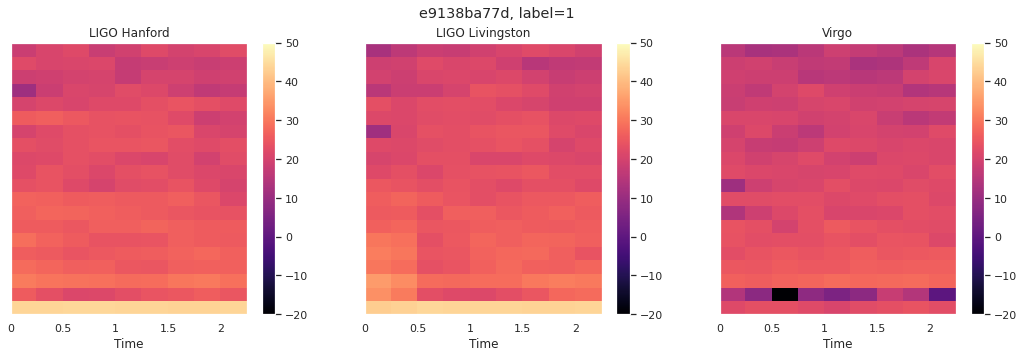

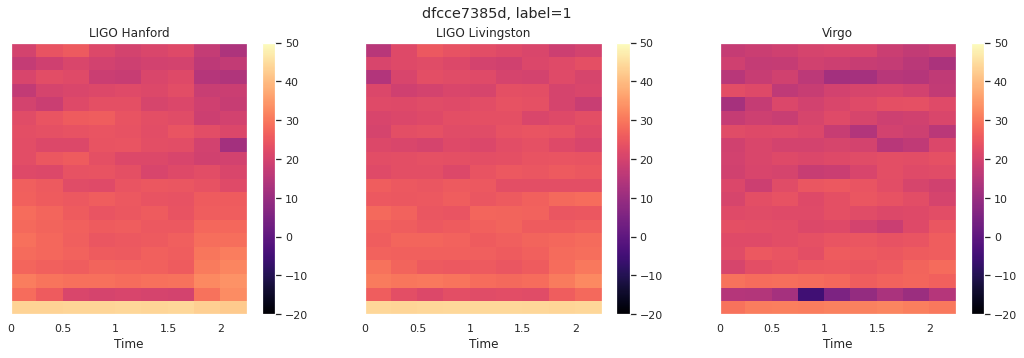

In [72]:
sample_ids = get_random_sample_ids(labels, n=3)

sites = "LIGO Hanford", "LIGO Livingston", "Virgo"
for label in (0, 1):
    for sample_id in sample_ids[label]:
        sample_X = get_data_by_sample_id(sample_id, 'train')
        sample_y = get_label_by_sample_id(sample_id, labels)
        plot_mfc(sample_X, sample_y, sample_id)

## 2.3 Spectrograms by constant Q transform (CQT) <a class="anchor" id="spectrograms-CQT"></a>

In [17]:
def plot_cqt(sample_X, sample_y, sample_id, cqt):
    global sites
    fig, axes = plt.subplots(1, 4, figsize=(18,5))
    _ = plt.suptitle(f"{sample_id}, label={sample_y}")
    for i, site in enumerate(sites):
        X = sample_X[i]
        X = X / X.max()
        X = torch.from_numpy(X).float()
        X_cqt = cqt(X)

        ax = plt.subplot(1, 4, i+1)
        _ = ax.set(title=site)
        _ = plt.imshow(X_cqt.squeeze())

    X = np.hstack(sample_X) 
    X = X / X.max()
    X = torch.from_numpy(X).float()
    X_cqt = cqt(X)

    ax = plt.subplot(1, 4, 4)
    _ = ax.set(title="3 sites")
    _ = plt.imshow(X_cqt.squeeze())


CQT kernels created, time used = 0.0081 seconds


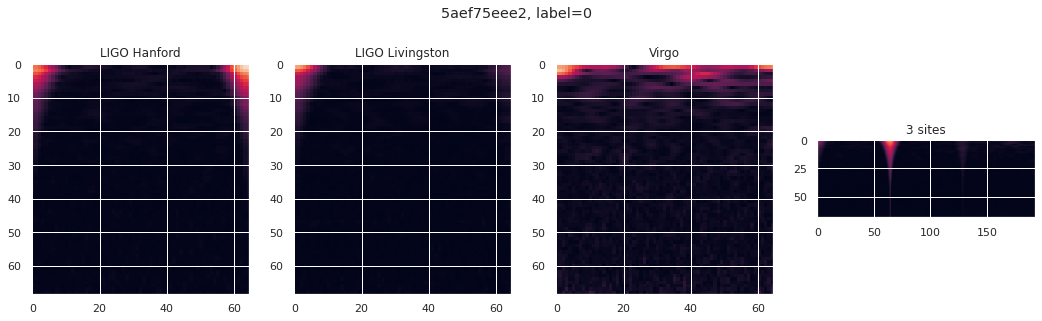

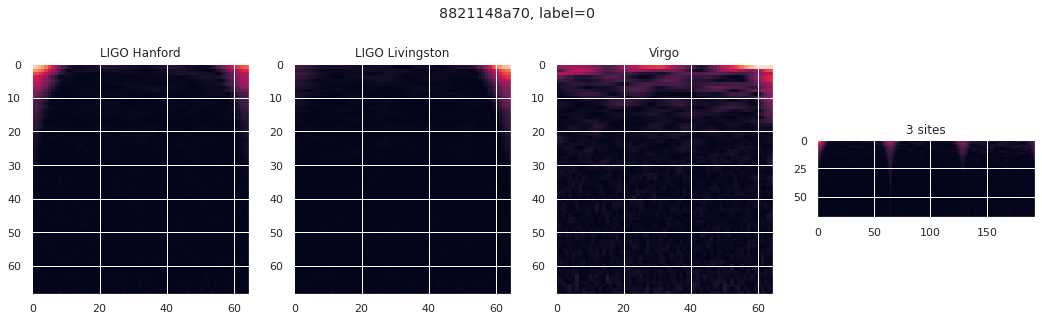

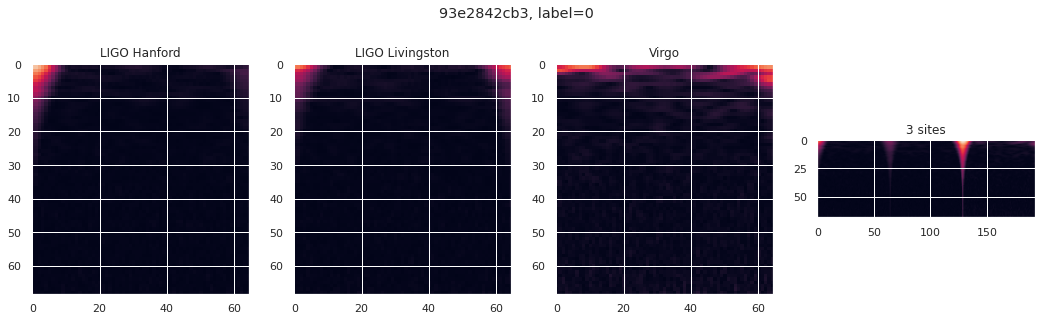

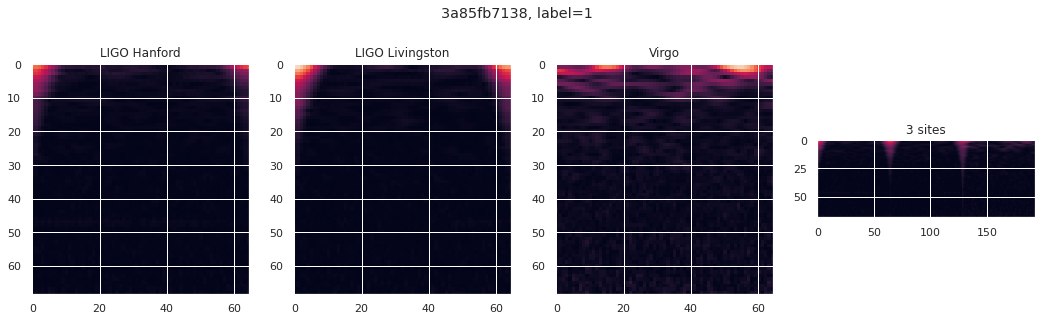

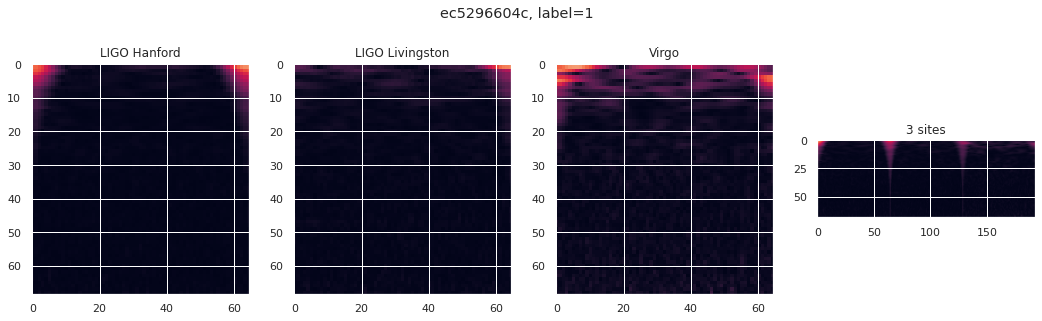

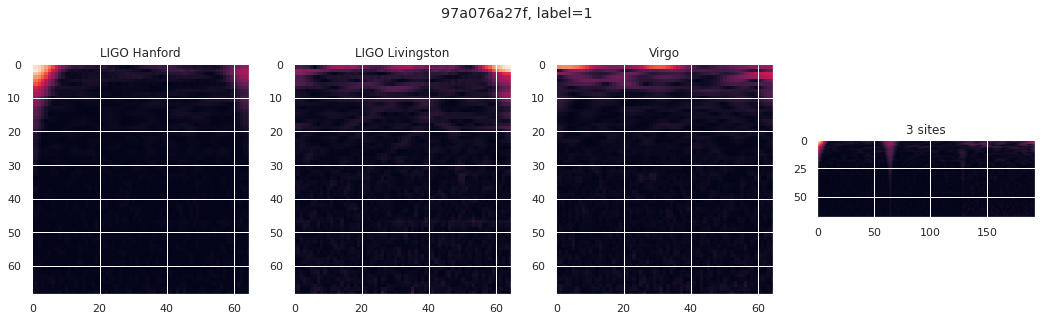

In [18]:
cqt = CQT1992v2(sr=2048, hop_length=64, fmin=20, fmax=1024)
sample_ids = get_random_sample_ids(labels, n=3)

sites = "LIGO Hanford", "LIGO Livingston", "Virgo"
for label in (0, 1):
    for sample_id in sample_ids[label]:
        sample_X = get_data_by_sample_id(sample_id, 'train')
        sample_y = get_label_by_sample_id(sample_id, labels)
        plot_cqt(sample_X, sample_y, sample_id, cqt)

## 2.4 Scalograms by wavelet transform <a class="anchor" id="scalograms-wavelet"></a>

In [245]:
def plot_scalograms(sample_X, sample_y, sample_id):
    global sites
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    _ = plt.suptitle(f"{sample_id}, label={sample_y}")
    for i, site in enumerate(sites):
        X = sample_X[i]
        X = X / X.max()
        X_cwt, freqs = pywt.cwt(X, scales=np.arange(1, 300), wavelet='morl', sampling_period=1/2048)
        ax = plt.subplot(1, 3, i+1)
        _ = ax.set(title=site)
        _ = plt.imshow(X_cwt, cmap='coolwarm', aspect='auto', vmin=-15, vmax=15)
        y_ticks = np.arange(0, len(freqs), len(freqs)/10).astype(int)
        t = np.arange(4096)/2048
        x_ticks = np.arange(0, len(t), len(t)/4).astype(int)
        _ = ax.set(yticks=y_ticks, yticklabels=freqs[y_ticks].round(1), ylabel='Hz', xticks=x_ticks, xticklabels=t[x_ticks], xlabel='Time (s)')
        _ = plt.colorbar()

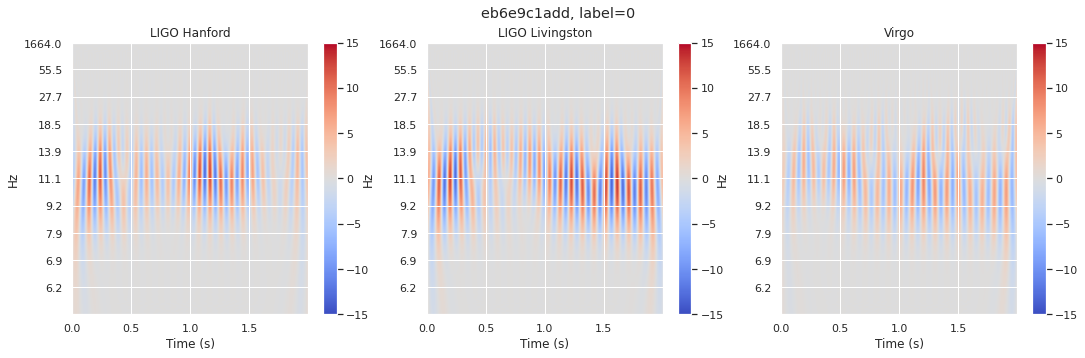

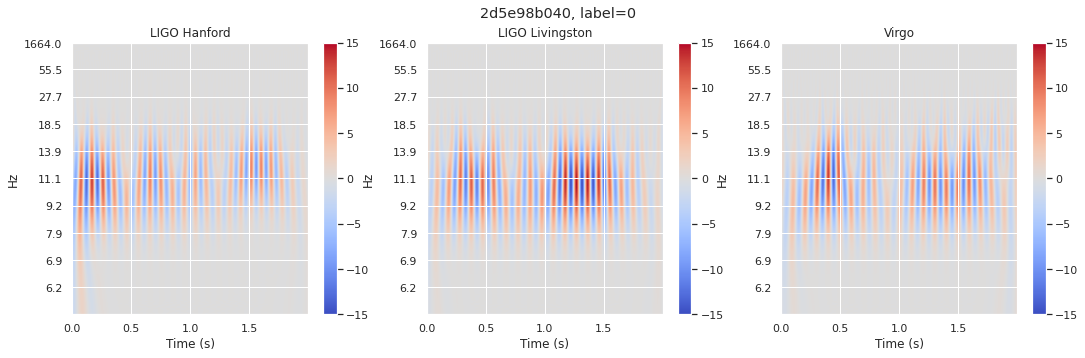

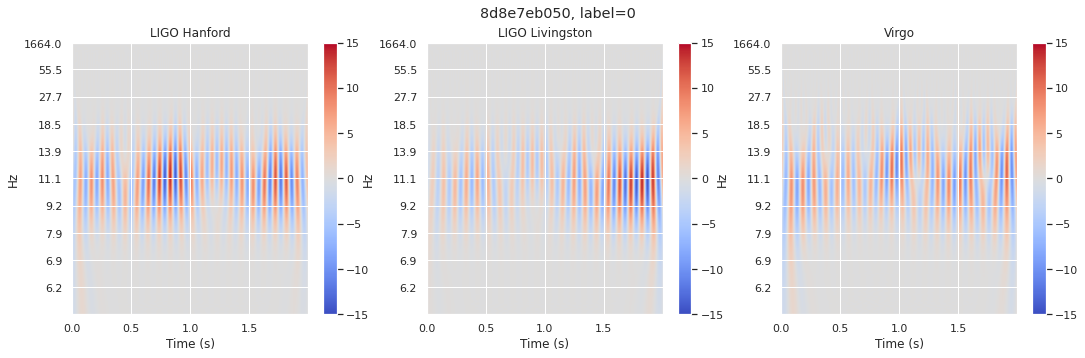

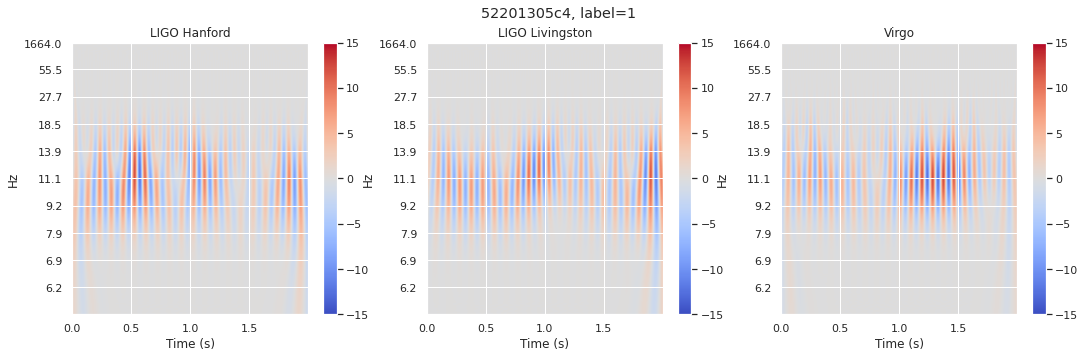

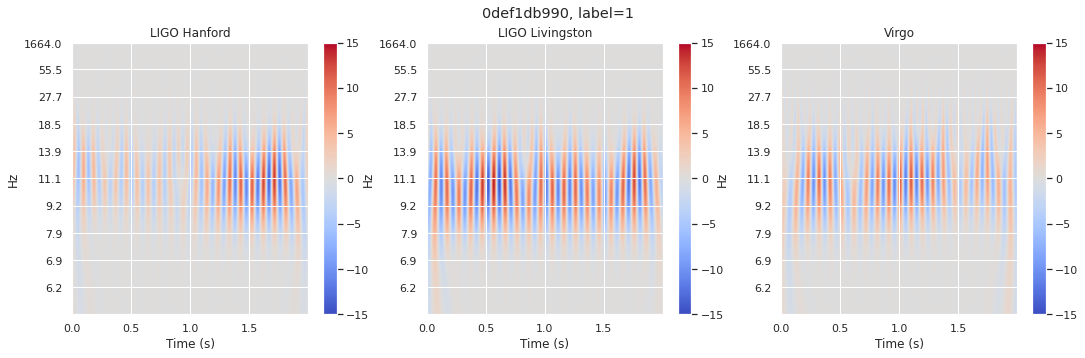

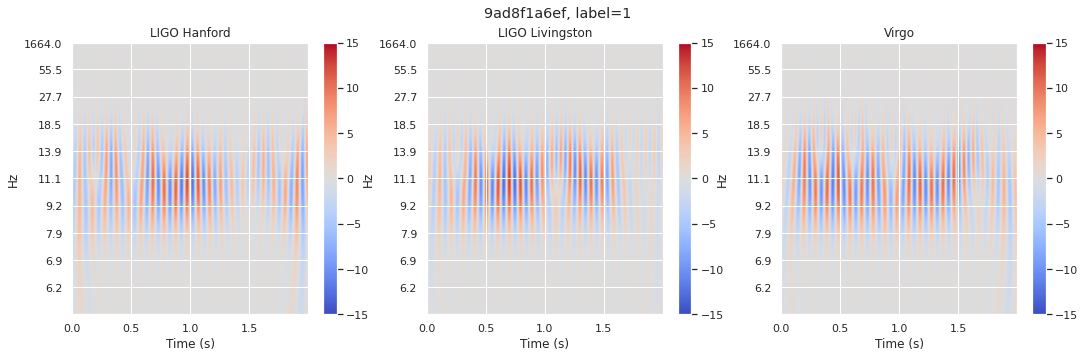

In [246]:
sample_ids = get_random_sample_ids(labels, n=3)

sites = "LIGO Hanford", "LIGO Livingston", "Virgo"
for label in (0, 1):
    for sample_id in sample_ids[label]:
        sample_X = get_data_by_sample_id(sample_id, 'train')
        sample_y = get_label_by_sample_id(sample_id, labels)
        plot_scalograms(sample_X, sample_y, sample_id)

# 3 Time-frequency analysis on filtered data <a class="anchor" id="time-frequency-analysis-filtered-data"></a>

The purpose of signal fitlering is to remove the low-frequency components, which have much higher power than high-frequency components and supress the high-frequency features to be identitied by neural networks.

## 3.1 High-pass filter <a class="anchor" id="high-pass-filter"></a>

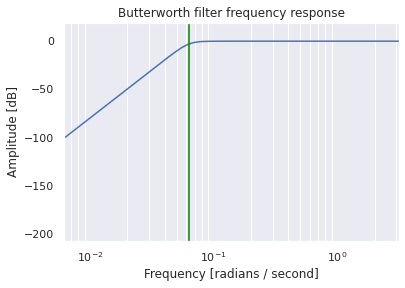

In [24]:
filter_sos = signal.butter(N=5, Wn=20.43, btype='highpass', output='sos', fs=2048)
b, a = signal.butter(N=5, Wn=20.43, btype='highpass', output='ba', fs=2048)
w, h = signal.freqz(b, a)
_ = plt.semilogx(w, 20 * np.log10(abs(h)))
_ = plt.title('Butterworth filter frequency response')
_ = plt.xlabel('Frequency [radians / second]')
_ = plt.ylabel('Amplitude [dB]')
_ = plt.margins(0, 0.1)
_ = plt.grid(which='both', axis='both')
_ = plt.axvline((20.43/2048)*2*np.pi, color='green') # cutoff frequency

## 3.2 Filtered signal time domain plots <a class='anchor' id='filtered-signal-time-domain-plots'>

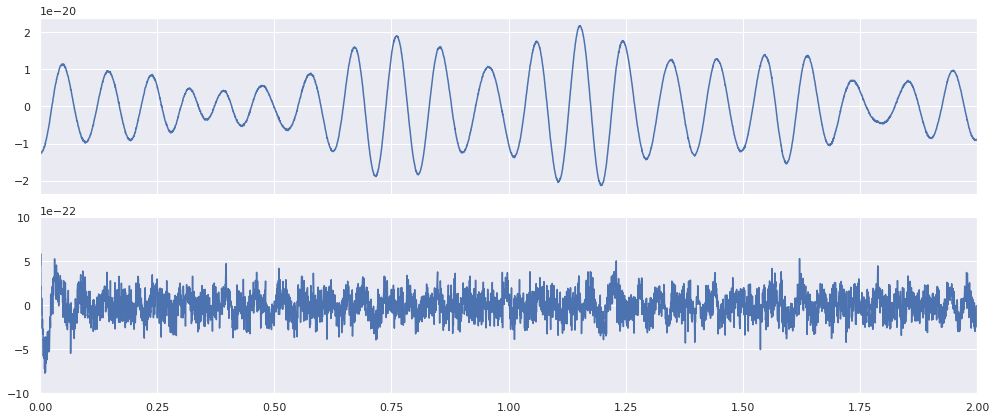

In [25]:
sample_id = '1eaebf260b' # label=1
sample_X = get_data_by_sample_id(sample_id)
sample_y = get_label_by_sample_id(sample_id, labels)
X_filt = signal.sosfiltfilt(sos, sample_X)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
t = np.arange(0, 2, 2/4096)
_ = ax1.plot(t, sample_X[0])
_ = ax2.plot(t, X_filt[0])
_ = ax2.axis([0, 2, -1e-21, 1e-21])
_ = plt.tight_layout()

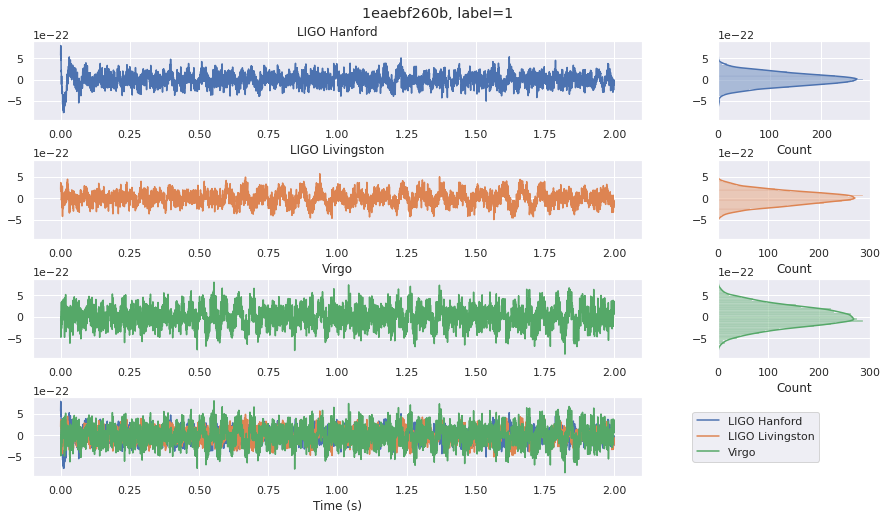

In [27]:
plot_sample(X_filt, sample_id, label=y)

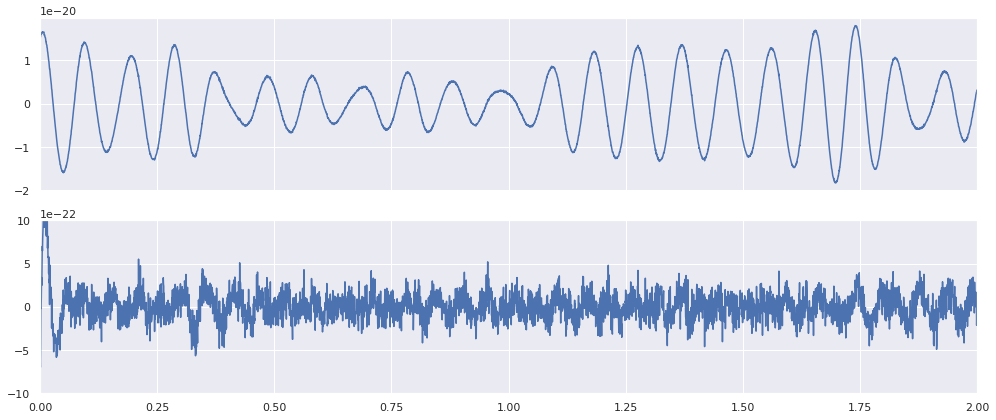

In [57]:
sample_id = 'f1040ce058' # label=0
sample_X = get_data_by_sample_id(sample_id)
sample_y = get_label_by_sample_id(sample_id, labels)
X_filt = signal.sosfiltfilt(sos, sample_X)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
t = np.arange(0, 2, 2/4096)
_ = ax1.plot(t, sample_X[0])
_ = ax2.plot(t, X_filt[0])
_ = ax2.axis([0, 2, -1e-21, 1e-21])
_ = plt.tight_layout()

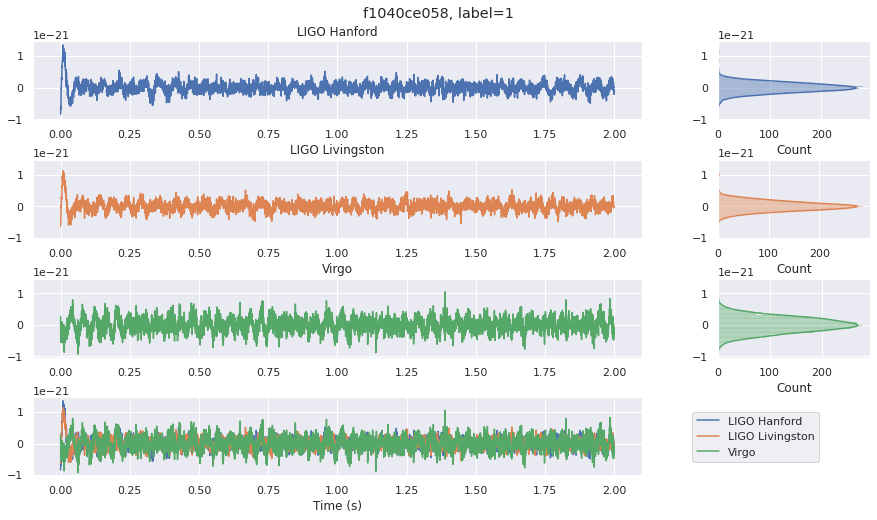

In [58]:
plot_sample(X_filt, sample_id, label=y)

## 3.3 CQT spectrograms <a class="anchor" id="filtered-CQT-spectrograms"></a>

In [55]:
def plot_cqt_filter_raw(X, X_filt, cqt, sample_y, sample_id):
    X = np.hstack(X) 
    X = X / X.max()
    X = torch.from_numpy(X).float()

    X_filt = np.hstack(X_filt) 
    X_filt = X_filt / X_filt.max()
    X_filt = torch.from_numpy(X_filt).float()

    fig, axes = plt.subplots(1, 2, figsize=(22,10))
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Filtered signal')
    _ = plt.imshow(cqt(X_filt).squeeze())
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Raw signal')
    _ = plt.imshow(cqt(X).squeeze())
    _ = plt.suptitle(f"{sample_id}, label={sample_y}", y=0.68)

def plot_sample_filter_spectrogram(sample_id, filter_sos):
    cqt = CQT1992v2(sr=2048, hop_length=64, fmin=20, fmax=1024)
    X = get_data_by_sample_id(sample_id)
    y = get_label_by_sample_id(sample_id, labels)
    X_filt = signal.sosfiltfilt(filter_sos, sample_X)
    plot_cqt_filter_raw(X, X_filt, cqt, y, sample_id)

CQT kernels created, time used = 0.0090 seconds


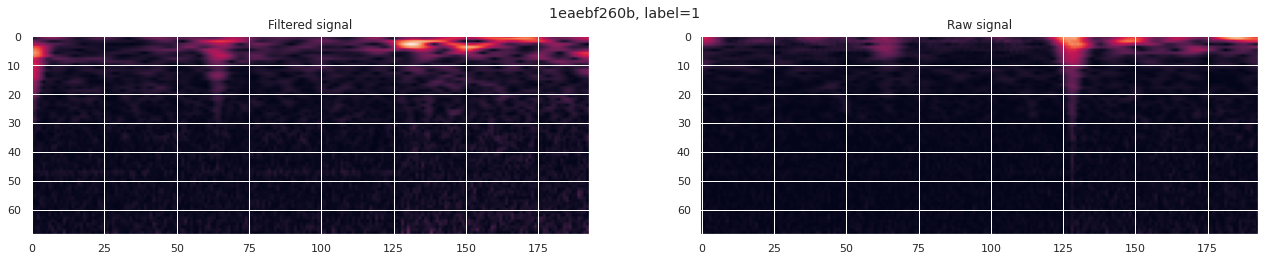

In [56]:

sample_id = '1eaebf260b' # label=1
plot_sample_filter_spectrogram(sample_id, filter_sos)

CQT kernels created, time used = 0.0100 seconds


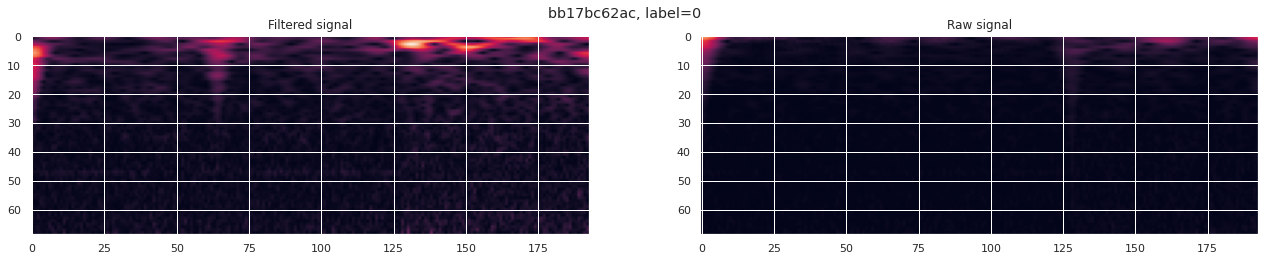

In [60]:
sample_id = 'bb17bc62ac' # label=0
plot_sample_filter_spectrogram(sample_id, filter_sos)